In [1]:
import pandas as pd
import os

# Paths
save_dir = r'C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410'
os.makedirs(save_dir, exist_ok=True)

deployments_path = save_dir + r'\ssusa_finaldeployments.csv'
snapshot_path = save_dir + r'\merged_snapshot_usa.csv'

# Load both CSVs
df_deployments = pd.read_csv(deployments_path)
df_snapshot = pd.read_csv(snapshot_path)

# Ensure Deployment_ID is string (optional, in case of leading zeros etc.)
df_deployments['Deployment_ID'] = df_deployments['Deployment_ID'].astype(str)
df_snapshot['Deployment_ID'] = df_snapshot['Deployment_ID'].astype(str)

# Filter deployments for Deployment_IDs in snapshot
df_filtered = df_deployments[df_deployments['Deployment_ID'].isin(df_snapshot['Deployment_ID'])]

# Keep only the first occurrence of each Deployment_ID
df_first_occurrence = df_filtered.drop_duplicates(subset='Deployment_ID', keep='first')

# Keep only relevant columns
df_result = df_first_occurrence[['Deployment_ID', 'Latitude', 'Longitude']]

# Show result
print(df_result)

# Optional: Save to CSV
# df_result.to_csv(save_dir + r'\filtered_deployments_lat_lon.csv', index=False)


C:\Users\sagni\AppData\Local\Temp\ipykernel_11636\3824015723.py:13: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_snapshot = pd.read_csv(snapshot_path)


                            Deployment_ID  Latitude  Longitude
0                 Harrods Hill 08/06/2022   38.0164   -84.5642
1                    Idle Hour 08/06/2022   38.0200   -84.4586
2                Jacobson Park 08/06/2022   37.9886   -84.4158
3                    Lake View 08/06/2022   38.0125   -84.4705
4           Lexington Cemetery 09/30/2022   38.0630   -84.5124
...                                   ...       ...        ...
9674   TX_Forest_SubUrban_SanMarcos_D1.44   29.9000   -98.0000
9675   TX_Forest_SubUrban_SanMarcos_D2.42   29.9000   -98.0000
9676                            NC_SSUSA3   35.9000   -75.9000
9677  NC_Forest_Alligator_River_NWR_20_08   35.8000   -75.9000
9678  NC_Forest_Alligator_River_NWR_20_09   35.8000   -75.9000

[9554 rows x 3 columns]


In [14]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics.pairwise import haversine_distances
from geopy.distance import geodesic
from pyproj import Transformer
from itertools import combinations

# Copy to avoid SettingWithCopyWarning
df_result = df_result.copy()
transformer = Transformer.from_crs("epsg:4326", "epsg:32633", always_xy=True)

# === Step 1: K-means === #
df_result['x'], df_result['y'] = transformer.transform(
    df_result['Longitude'].values,
    df_result['Latitude'].values
)

k = 100
kmeans = KMeans(n_clusters=k, random_state=42)
df_result['Cluster_KMeans'] = kmeans.fit_predict(df_result[['x', 'y']].values)
df_result = df_result[['Deployment_ID', 'Latitude', 'Longitude', 'x', 'y', 'Cluster_KMeans']]

df_result.head()

,Deployment_ID,Latitude,Longitude,x,y,Cluster_KMeans
0,Harrods Hill 08/06/2022,38.0164,-84.5642,-6.115975e+06,1.133085e+07,98
1,Idle Hour 08/06/2022,38.0200,-84.4586,-6.119196e+06,1.131651e+07,98
2,Jacobson Park 08/06/2022,37.9886,-84.4158,-6.126073e+06,1.131219e+07,98
3,Lake View 08/06/2022,38.0125,-84.4705,-6.120039e+06,1.131845e+07,98
4,Lexington Cemetery 09/30/2022,38.0630,-84.5124,-6.109956e+06,1.132176e+07,98


In [15]:
from sklearn.cluster import AgglomerativeClustering

# Use projected coords 'x', 'y' (in meters)
agglo = AgglomerativeClustering(
    n_clusters=None,          # Use distance threshold mode
    distance_threshold=50000, # 50 km in meters
    linkage='single'          # single linkage to ensure max pairwise distance in cluster <= threshold
)

df_result['Cluster_Agglo'] = agglo.fit_predict(df_result[['x', 'y']])

df_result[['Deployment_ID', 'Latitude', 'Longitude', 'Cluster_KMeans', 'Cluster_Agglo']].head()

,Deployment_ID,Latitude,Longitude,Cluster_KMeans,Cluster_Agglo
0,Harrods Hill 08/06/2022,38.0164,-84.5642,98,28
1,Idle Hour 08/06/2022,38.0200,-84.4586,98,28
2,Jacobson Park 08/06/2022,37.9886,-84.4158,98,28
3,Lake View 08/06/2022,38.0125,-84.4705,98,28
4,Lexington Cemetery 09/30/2022,38.0630,-84.5124,98,28


In [16]:
import numpy as np
from sklearn.cluster import DBSCAN

# Convert degrees to radians
coords = np.radians(df_result[['Latitude', 'Longitude']].values)

# Earth radius in kilometers
earth_radius_km = 6371.0

# 50 km in radians
eps_rad = 50 / earth_radius_km

# DBSCAN with haversine metric
dbscan = DBSCAN(eps=eps_rad, min_samples=1, metric='haversine')

df_result['Cluster_DBSCAN'] = dbscan.fit_predict(coords)

df_result[['Deployment_ID', 'Latitude', 'Longitude', 'Cluster_KMeans', 'Cluster_Agglo', 'Cluster_DBSCAN']].head()


,Deployment_ID,Latitude,Longitude,Cluster_KMeans,Cluster_Agglo,Cluster_DBSCAN
0,Harrods Hill 08/06/2022,38.0164,-84.5642,98,28,0
1,Idle Hour 08/06/2022,38.0200,-84.4586,98,28,0
2,Jacobson Park 08/06/2022,37.9886,-84.4158,98,28,0
3,Lake View 08/06/2022,38.0125,-84.4705,98,28,0
4,Lexington Cemetery 09/30/2022,38.0630,-84.5124,98,28,0


C:\Users\sagni\AppData\Local\Temp\ipykernel_11636\1229041454.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, patch_artist=True,


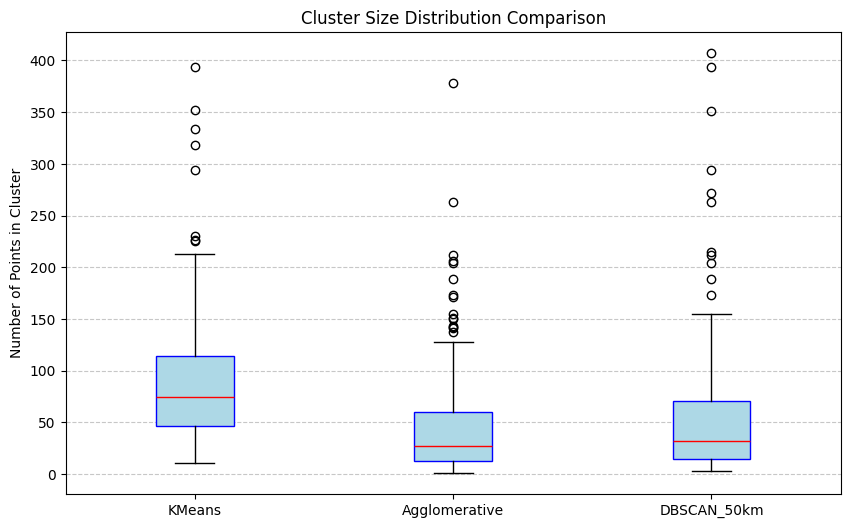

In [18]:
# Step 1: Calculate cluster counts for each clustering method
count_kmeans = df_result.groupby('Cluster_KMeans').size()
count_agglo = df_result.groupby('Cluster_Agglo').size()
count_dbscan = df_result.groupby('Cluster_DBSCAN').size()

# Step 2: Prepare data and labels for boxplot
data = [count_kmeans.values, count_agglo.values, count_dbscan.values]
labels = ['KMeans', 'Agglomerative', 'DBSCAN_50km']

# Step 3: Plot boxplots side-by-side
plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'))

plt.title('Cluster Size Distribution Comparison')
plt.ylabel('Number of Points in Cluster')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

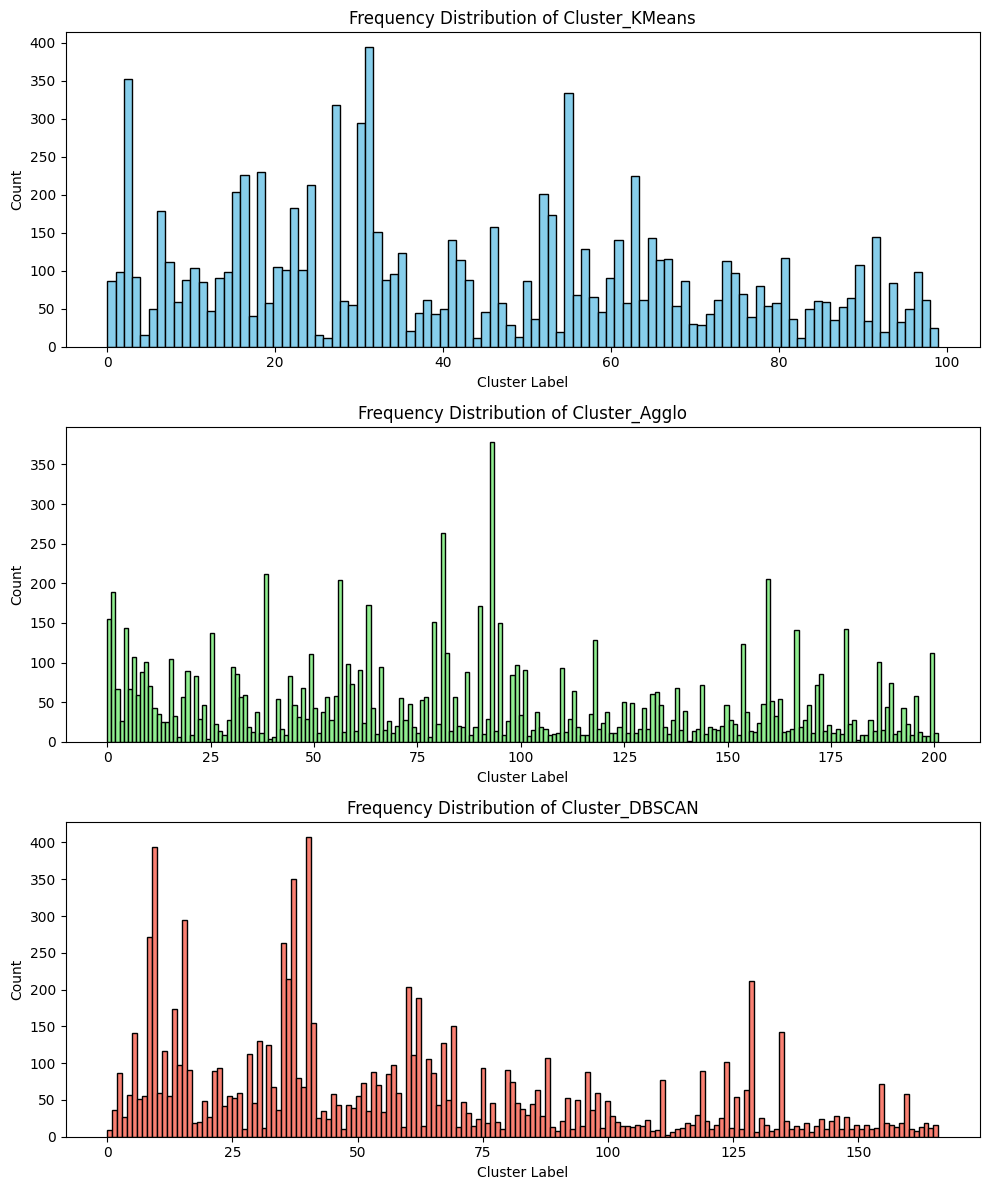

In [20]:
import matplotlib.pyplot as plt

# Set up the plot grid: 3 rows, 1 column
fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# Histogram for Cluster_KMeans
axes[0].hist(df_result['Cluster_KMeans'], bins=df_result['Cluster_KMeans'].nunique(), color='skyblue', edgecolor='black')
axes[0].set_title('Frequency Distribution of Cluster_KMeans')
axes[0].set_xlabel('Cluster Label')
axes[0].set_ylabel('Count')

# Histogram for Cluster_Agglo
axes[1].hist(df_result['Cluster_Agglo'], bins=df_result['Cluster_Agglo'].nunique(), color='lightgreen', edgecolor='black')
axes[1].set_title('Frequency Distribution of Cluster_Agglo')
axes[1].set_xlabel('Cluster Label')
axes[1].set_ylabel('Count')

# Histogram for Cluster_DBSCAN_50km
axes[2].hist(df_result['Cluster_DBSCAN'], bins=df_result['Cluster_DBSCAN'].nunique(), color='salmon', edgecolor='black')
axes[2].set_title('Frequency Distribution of Cluster_DBSCAN')
axes[2].set_xlabel('Cluster Label')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [23]:
from geopy.distance import geodesic
from itertools import combinations
import pandas as pd
import numpy as np
import os

def cluster_distance_stats_df(
    df,
    cluster_col='Cluster_KMeans',
    lat_col='Latitude',
    lon_col='Longitude',
    output_dir=r'C:\Users\sagni\Documents\Personal Files\Research\doi_10_5061_dryad_k0p2ngfhn__v20250410'
):
    clusters = df[cluster_col].unique()
    results = []

    for c in sorted(clusters):
        cluster_points = df[df[cluster_col] == c][[lat_col, lon_col]].values
        
        count = len(cluster_points)
        if count < 2:
            results.append({
                'cluster_id': c,
                'count': count,
                'min_distance_km': np.nan,
                'avg_distance_km': np.nan,
                'max_distance_km': np.nan
            })
            continue
        
        distances = [
            geodesic((lat1, lon1), (lat2, lon2)).km
            for (lat1, lon1), (lat2, lon2) in combinations(cluster_points, 2)
        ]
        
        results.append({
            'cluster_id': c,
            'count': count,
            'min_distance_km': min(distances),
            'avg_distance_km': sum(distances) / len(distances),
            'max_distance_km': max(distances)
        })
    
    Output = pd.DataFrame(results).sort_values('cluster_id').reset_index(drop=True)
    
    # Ensure directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Full path for output file
    filename = f"{cluster_col}.xlsx"
    filepath = os.path.join(output_dir, filename)
    
    Output.to_excel(filepath, index=False)
    
    return Output

# Example usage
cluster_stats_df = cluster_distance_stats_df(
    df_result, 
    cluster_col='Cluster_KMeans'
)
print(cluster_stats_df)


    cluster_id  count  min_distance_km  avg_distance_km  max_distance_km
0            0     86         0.004436         0.379982         0.848609
1            1     98         0.000000        25.541998       126.894905
2            2    352         0.000000        53.096137       122.485426
3            3     92         0.000000        52.467526       250.990105
4            4     16         0.320614         2.786008         6.955631
..         ...    ...              ...              ...              ...
95          95     33         0.011435        83.007733       185.863372
96          96     50         0.000000         1.671135         4.316069
97          97     98         0.000000        54.808714       101.042483
98          98     62         0.000000        59.324619       199.321525
99          99     25         0.302668        20.547755        38.145616

[100 rows x 5 columns]


In [24]:
cluster_stats_df = cluster_distance_stats_df(
    df_result, 
    cluster_col='Cluster_Agglo'
)
print(cluster_stats_df)


     cluster_id  count  min_distance_km  avg_distance_km  max_distance_km
0             0    155         0.000000        17.610304        35.409763
1             1    189         0.000000        17.236088        46.119170
2             2     67         0.000000        16.320153        33.249351
3             3     26         0.191004        17.957736        51.512177
4             4    143         0.000000        31.298508        94.704425
..          ...    ...              ...              ...              ...
197         197     12         0.200376         1.043538         3.254171
198         198      7         0.153282         0.335742         0.569034
199         199      7         0.105430         0.320037         0.675514
200         200    112         0.000000         1.495096         4.511519
201         201     11         0.002184         1.089728         2.343197

[202 rows x 5 columns]


In [25]:
cluster_stats_df = cluster_distance_stats_df(
    df_result, 
    cluster_col='Cluster_DBSCAN'
)
print(cluster_stats_df)

     cluster_id  count  min_distance_km  avg_distance_km  max_distance_km
0             0      9         1.336035         7.544856        17.418396
1             1     37         0.055248        10.278454        29.021911
2             2     86         0.004436         0.379982         0.848609
3             3     27         0.000000         0.540039         1.065564
4             4     57         0.000000         0.947266         2.713798
..          ...    ...              ...              ...              ...
162         162      8         0.206149         0.670950         1.607386
163         163     13         0.881549         7.016700        17.167417
164         164     18         1.059061        10.600454        25.671959
165         165     12         0.200376         1.043538         3.254171
166         166     16         0.000086         0.532818         1.066992

[167 rows x 5 columns]
